Mounted at /content/drive
Dataset shape: (1464, 4)

First rows:


,date,avg_price,volume,ticker
0,2023-01-01,16561.335,3.352209e+08,BTC
1,2023-01-02,16656.110,5.033604e+08,BTC
2,2023-01-03,16685.855,6.285822e+08,BTC
3,2023-01-04,16811.820,9.906893e+08,BTC
4,2023-01-05,16817.240,5.245115e+08,BTC


/tmp/ipython-input-2034273950.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


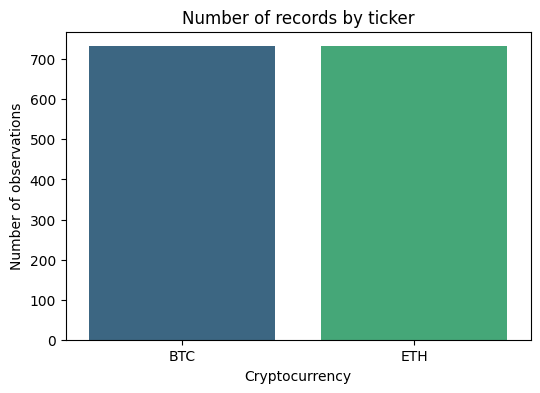

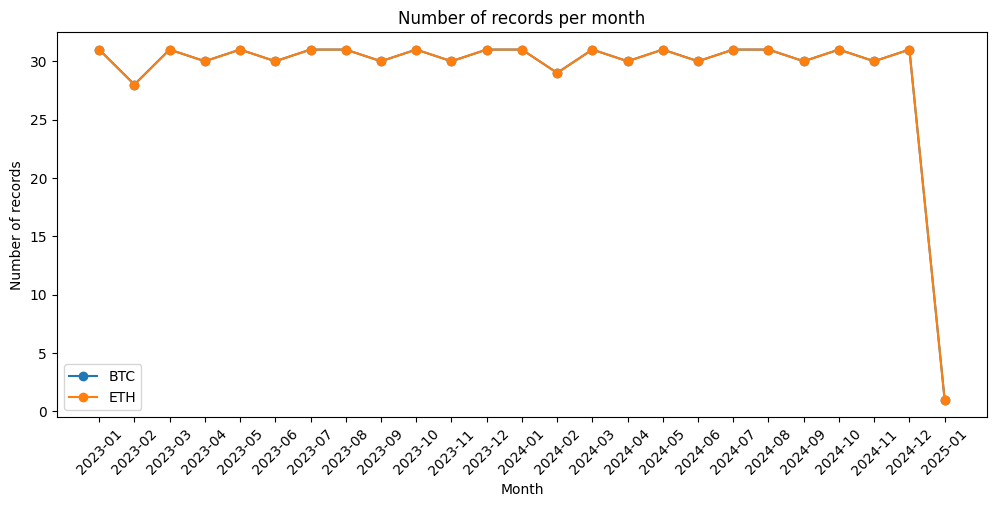

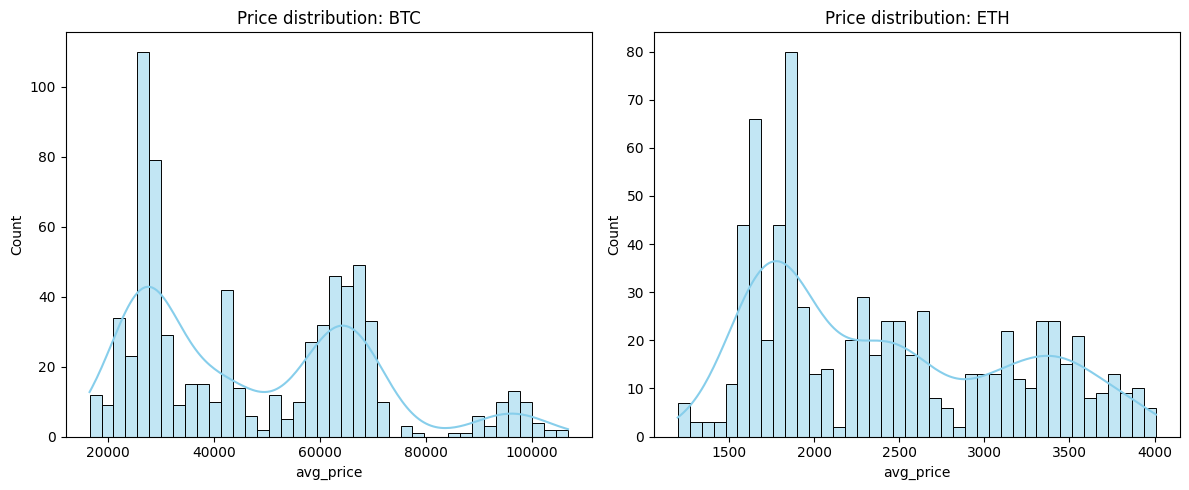

/tmp/ipython-input-2034273950.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="ticker", y="avg_price", data=df, palette="pastel")


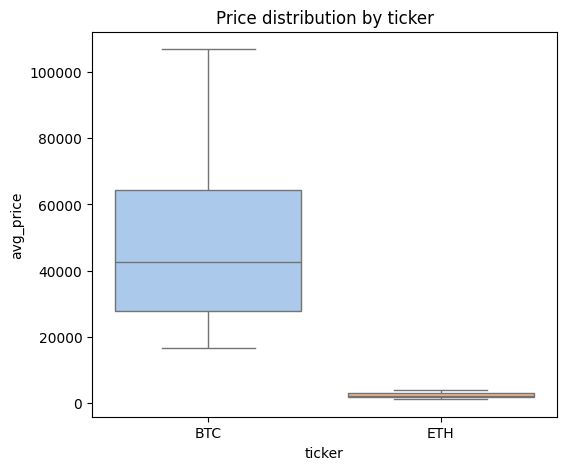

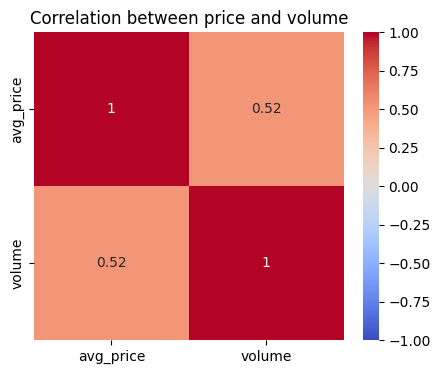


[Spark SQL] Monthly aggregates (first rows):
+------+----+---+------------------+--------------------+
|ticker|y   |m  |monthly_avg_price |monthly_avg_volume  |
+------+----+---+------------------+--------------------+
|BTC   |2023|1  |20160.385967741935|1.2571720268654842E9|
|BTC   |2023|2  |23307.10178571429 |1.1308345866660712E9|
|BTC   |2023|3  |25050.094193548386|1.3795680694480646E9|
|BTC   |2023|4  |28851.107166666665|9.432897673156666E8 |
|BTC   |2023|5  |27512.852903225805|6.968809180993547E8 |
|BTC   |2023|6  |27723.187166666667|6.987233601986668E8 |
|BTC   |2023|7  |30099.816774193554|4.7316168831935495E8|
|BTC   |2023|8  |27855.754838709676|4.7491610116870964E8|
|BTC   |2023|9  |26308.72816666666 |4.400226051206666E8 |
|BTC   |2023|10 |29713.217580645156|8.120941657125806E8 |
|BTC   |2023|11 |36524.017166666665|9.518301370643333E8 |
|BTC   |2023|12 |42429.411129032254|1.1961175915025804E9|
+------+----+---+------------------+--------------------+
only showing top 12 rows



In [ ]:
# ============================================================
# Big Data Processing + Exploratory Data Analysis (EDA)
# ============================================================

# -----------------------------
# Block 0. Install dependencies
# -----------------------------
!pip -q install pandas pyspark requests pycryptodome seaborn matplotlib

# ------------------------------------------
# Block 1. Environment and Google Drive setup
# ------------------------------------------
from google.colab import drive
import os
drive.mount('/content/drive')

PROJECT_DIR = "/content/drive/MyDrive/crypto_analysis_sqlcube"
os.makedirs(PROJECT_DIR, exist_ok=True)

# ---------------------------------
# Block 2. Initialize SQLite (OLTP)
# ---------------------------------
import sqlite3
DB_PATH = os.path.join(PROJECT_DIR, "crypto.db")
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

cursor.executescript("""
PRAGMA journal_mode=WAL;

CREATE TABLE IF NOT EXISTS Cryptocurrency (
    crypto_id INTEGER PRIMARY KEY,
    ticker TEXT NOT NULL UNIQUE,
    name   TEXT NOT NULL
);

CREATE TABLE IF NOT EXISTS Date (
    date_id INTEGER PRIMARY KEY,
    year  INTEGER NOT NULL,
    month INTEGER NOT NULL,
    day   INTEGER NOT NULL,
    UNIQUE (year, month, day)
);

CREATE TABLE IF NOT EXISTS PriceData (
    price_id  INTEGER PRIMARY KEY,
    crypto_id INTEGER NOT NULL,
    date_id   INTEGER NOT NULL,
    avg_price REAL,
    volume    REAL,
    FOREIGN KEY (crypto_id) REFERENCES Cryptocurrency(crypto_id),
    FOREIGN KEY (date_id)   REFERENCES Date(date_id)
);
""")
conn.commit()

# ------------------------------------------------
# Block 3. Fetch historical data from CryptoCompare
# ------------------------------------------------
import pandas as pd
import requests
from datetime import datetime
import time

def get_crypto_data(symbol: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    base_url = "https://min-api.cryptocompare.com/data/v2/histoday"
    total_days = (end_date - start_date).days
    params = {
        "fsym": symbol,
        "tsym": "USD",
        "limit": min(total_days, 2000),
        "toTs": int(end_date.timestamp())
    }
    r = requests.get(base_url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    if data.get("Response") != "Success":
        raise ValueError(f"API error for {symbol}: {data.get('Message')}")
    df = pd.DataFrame(data["Data"]["Data"])
    if df.empty:
        return pd.DataFrame(columns=["date","avg_price","volume","ticker"])
    df["date"] = pd.to_datetime(df["time"], unit="s")
    df["avg_price"] = (df["high"] + df["low"]) / 2.0
    df["volume"] = df["volumeto"]
    df = df[["date", "avg_price", "volume"]]
    df = df[(df["date"] >= start_date) & df["avg_price"].gt(0) & df["date"].notna()]
    return df

coins = {"BTC": "Bitcoin", "ETH": "Ethereum"}
start_date = datetime(2023, 1, 1)
end_date   = datetime(2025, 1, 1)

frames = []
for sym, name in coins.items():
    df_tmp = get_crypto_data(sym, start_date, end_date)
    df_tmp["ticker"] = sym
    frames.append(df_tmp)
    time.sleep(1)

raw_df = pd.concat(frames, ignore_index=True)
raw_csv_path = os.path.join(PROJECT_DIR, "crypto_raw_data.csv")
raw_df.to_csv(raw_csv_path, index=False)

# ======================================================
# Block 4. Exploratory Data Analysis (EDA)
# ======================================================
import seaborn as sns
import matplotlib.pyplot as plt

df = raw_df.copy()

# 1. Dataset size
print("Dataset shape:", df.shape)
print("\nFirst rows:")
display(df.head())

# 2. Record count by ticker
counts = df['ticker'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")
plt.title("Number of records by ticker")
plt.xlabel("Cryptocurrency")
plt.ylabel("Number of observations")
plt.show()

# 3. Time coverage (number of records per month)
df['year_month'] = df['date'].dt.to_period('M')
timeline = df.groupby(['year_month','ticker']).size().reset_index(name="count")
timeline['year_month'] = timeline['year_month'].astype(str)

plt.figure(figsize=(12,5))
for t in df['ticker'].unique():
    subset = timeline[timeline['ticker']==t]
    plt.plot(subset['year_month'], subset['count'], marker='o', label=t)
plt.xticks(rotation=45)
plt.title("Number of records per month")
plt.xlabel("Month")
plt.ylabel("Number of records")
plt.legend()
plt.show()

# 4. Price histograms
plt.figure(figsize=(12,5))
for i, t in enumerate(df['ticker'].unique()):
    plt.subplot(1,2,i+1)
    sns.histplot(df[df['ticker']==t]['avg_price'], bins=40, kde=True, color="skyblue")
    plt.title(f"Price distribution: {t}")
plt.tight_layout()
plt.show()

# 5. Boxplot of prices by ticker
plt.figure(figsize=(6,5))
sns.boxplot(x="ticker", y="avg_price", data=df, palette="pastel")
plt.title("Price distribution by ticker")
plt.show()

# 6. Correlation between price and volume
corr = df[['avg_price','volume']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between price and volume")
plt.show()

# ----------------------------------------------------
# Block 5. Spark: initialization and basic DataFrame prep
# ----------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, TimestampType
)
from pyspark.sql.functions import col, avg, year, month

spark = (
    SparkSession.builder
    .appName("CryptoPipelineAdvancedSQL")
    .config("spark.sql.shuffle.partitions", "4")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

schema = StructType([
    StructField("date", TimestampType(), True),
    StructField("avg_price", DoubleType(), True),
    StructField("volume", DoubleType(), True),
    StructField("ticker", StringType(), True),
])

sdf = spark.createDataFrame(raw_df, schema=schema)

# Register Temp View for SQL
sdf.createOrReplaceTempView("crypto")

# ----------------------------------------------
# Block 6. Spark SQL: monthly aggregates (OLAP-like)
# ----------------------------------------------
monthly_sql = spark.sql("""
SELECT
  ticker,
  YEAR(date)  AS y,
  MONTH(date) AS m,
  AVG(avg_price) AS monthly_avg_price,
  AVG(volume)    AS monthly_avg_volume
FROM crypto
GROUP BY ticker, YEAR(date), MONTH(date)
ORDER BY ticker, y, m
""")

# ------------------------------------------------------
# Block 7. Window Functions: 7-day moving average
# ------------------------------------------------------
from pyspark.sql.window import Window
from pyspark.sql.functions import avg as favg, row_number

w = Window.partitionBy("ticker").orderBy(col("date").cast("long")).rowsBetween(-7, 0)
with_ma = sdf.withColumn("ma_7d", favg("avg_price").over(w))

w2 = Window.partitionBy("ticker").orderBy(col("date").desc())
with_rank = with_ma.withColumn("rn", row_number().over(w2))
ma_tail = with_rank.filter(col("rn") <= 30).drop("rn")

# ---------------------------------------
# Block 8. OLAP Cube/Rollup via SQL
# ---------------------------------------
cube_sql = spark.sql("""
SELECT
  ticker,
  YEAR(date) AS y,
  MONTH(date) AS m,
  AVG(avg_price) AS avg_price_cube
FROM crypto
GROUP BY CUBE(ticker, YEAR(date), MONTH(date))
ORDER BY ticker, y, m
""")

rollup_sql = spark.sql("""
SELECT
  YEAR(date) AS y,
  MONTH(date) AS m,
  AVG(avg_price) AS avg_price_rollup
FROM crypto
GROUP BY ROLLUP(YEAR(date), MONTH(date))
ORDER BY y, m
""")

# --------------------------------------------
# Block 9. Demonstration of results (Spark + SQLite)
# --------------------------------------------
print("\n[Spark SQL] Monthly aggregates (first rows):")
monthly_sql.show(12, truncate=False)

print("\n[Spark] 7-day moving average (last rows per ticker):")
ma_tail.orderBy("ticker", col("date").desc()).show(8, truncate=False)

print("\n[Spark SQL] CUBE by (ticker, y, m) — sample:")
cube_sql.show(12, truncate=False)

print("\n[Spark SQL] ROLLUP by (y, m) — sample:")
rollup_sql.show(12, truncate=False)

# -----------------
# Block 10. Cleanup
# -----------------
#spark.stop()
##conn.close()
#drive.flush_and_unmount()